In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [7]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 227ms/step - loss: 0.2989 - root_mean_squared_error: 0.5467 - val_loss: 0.2141 - val_root_mean_squared_error: 0.4627
Epoch 2/50
53/53 [==============================] - 10s 188ms/step - loss: 0.1620 - root_mean_squared_error: 0.4025 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2898
Epoch 3/50
53/53 [==============================] - 12s 223ms/step - loss: 0.0867 - root_mean_squared_error: 0.2945 - val_loss: 0.0795 - val_root_mean_squared_error: 0.2819
Epoch 4/50
53/53 [==============================] - 11s 215ms/step - loss: 0.0770 - root_mean_squared_error: 0.2776 - val_loss: 0.0731 - val_root_mean_squared_error: 0.2703
Epoch 5/50
53/53 [==============================] - 10s 200ms/step - loss: 0.0680 - root_mean_squared_error: 0.2608 - val_loss: 0.0613 - val_root_mean_squared_error: 0.2477
Epoch 6/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0575 - root_mean_squared_error: 0.2397 - val_loss: 0.0503 

53/53 [==============================] - 11s 207ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 30/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 31/50
53/53 [==============================] - 10s 200ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 32/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0718
Epoch 33/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 34/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0051 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.349597505728403 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

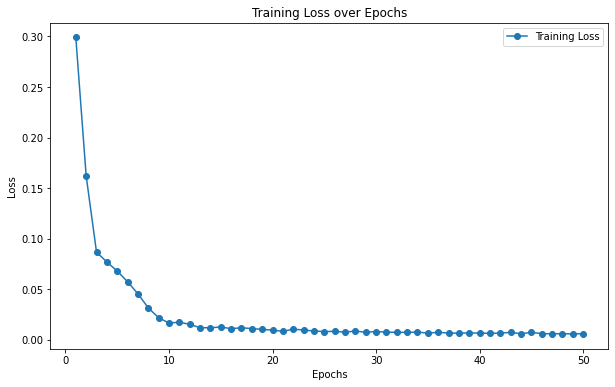

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

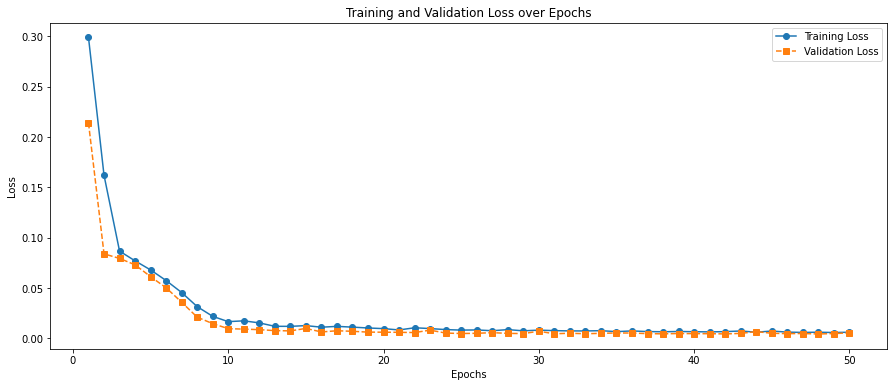

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model/')

In [9]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 23ms/step


In [10]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0566953765424597
MAE : 0.0461901128767212


In [11]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3276027.000,2787848.748
1,4435898.500,4544849.638
2,5362546.000,5882741.038
3,5910383.000,6574288.749
4,6250214.500,6669726.076
5,6289395.000,6516136.854
6,5652086.500,5902163.675
7,3684160.250,3498103.449
8,1644753.625,1633675.726
9,1229495.250,1292668.399


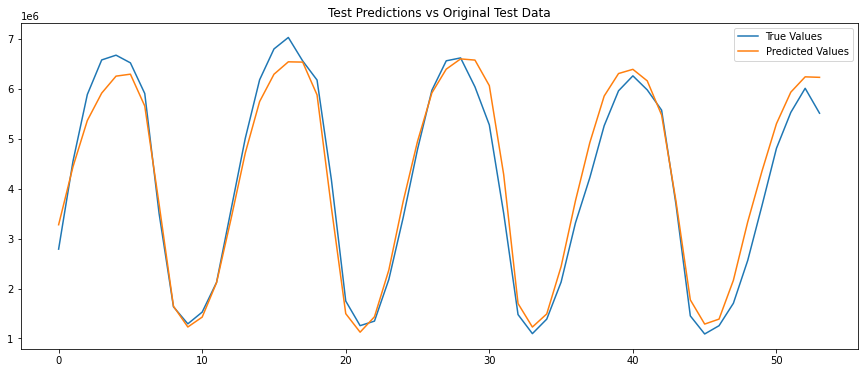

In [13]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [14]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

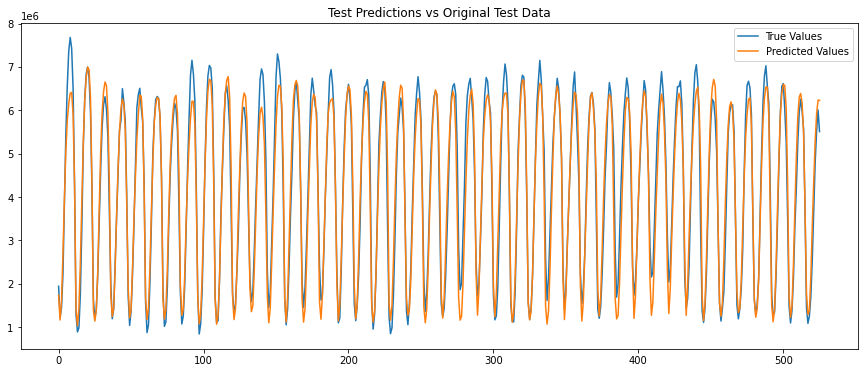

In [18]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()